In [44]:
def preprocessing (X,Y, num_method =0, ncor = 3):
    "Takes as input the dataset X and TARGETS Y\nImplements many possible preprocessing \nnum_method == 0 , on retire juste le pays et on remplace les NAN par des 0, proposition de base,\nnum_method == 1, on réordonne les jours, les premiers jours arrivent en premier dans le dataset, \nnum_method ==2, on crée une une nouvelle feature prix depuis la target,\nnum_method ==3, on retire les varibles plus corrélés"
        
    
    
    #un peu de code pour vérifier en entrée, teste juste les colonnes
    try:
        if np.any( X.keys() != ['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
           'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
           'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
           'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
           'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
           'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
           'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'] ): 
            raise InputError ("Vous avez rentré le mauvais dataframe X. Il ne contient pas les dimensions d'origine.")
        if np.any( Y.keys() !=['ID', 'TARGET']):
            raise InputError ("Vous avez rentré le mauvais dataframe Y. Il ne contient pas les dimensions d'origine.")

    except:
        raise TypeError("Ce n'est pas un dataframe")
        
    
    if num_method ==-1:
        X = X.fillna(0)
        X = X.get_dummies(X, columns=["COUNTRY"])
        
        
    ##Preprocessing classique, on fait ce qu'il y avait été proposé par les organisateurs
    if num_method == 0:
        return X.drop(['COUNTRY'], axis=1).fillna(0), Y_train['TARGET']
    
        ##rearrange les données en fonction du jours. Ca ne sert à rien
    if num_method == 1:
        data= pd.merge(X,Y, on = ['ID'])
        data.fillna(0).sort_values('DAY_ID')
        return data.drop(['TARGET'], axis =1), data['TARGET']
    
        ## c'est de la D, c'est un pb d'apprentissage supervisé et non un pb de 
    if num_method ==2 :
        data= pd.merge(X,Y, on = ['ID'])
        donnee_FR = data[data["COUNTRY"]=="FR"].fillna(0).sort_values('DAY_ID')
        donnee_DE = data[data["COUNTRY"]=="DE"].fillna(0).sort_values('DAY_ID')
        
        ##pour la france
        data_FR = donnee_FR.assign(PRICE = donnee_FR['TARGET'] )
        # ajouter une nouvelle colonne qui contient la somme de col1 pour la ligne actuelle et la ligne précédente
        data_FR['Variation_Price'] = ( data_FR['DAY_ID'] - data_FR['DAY_ID'].shift(1) -1 )*(data_FR['TARGET'].shift(1) + 
                                                                        data_FR['TARGET']) /2   +  data_FR['TARGET']
        ##CALCUL DU PRIX##
        # utiliser cumsum pour accumuler les valeurs de la nouvelle colonne
        data_FR['PRICE'] = data_FR['Variation_Price'].cumsum()
        
        
        data_DE = donnee_DE.assign(PRICE = donnee_DE['TARGET'] )
        # ajouter une nouvelle colonne qui contient la somme de col1 pour la ligne actuelle et la ligne précédente
        data_DE['Variation_Price'] = ( data_DE['DAY_ID'] - data_DE['DAY_ID'].shift(1) -1 )*(data_DE['TARGET'].shift(1) + 
                                                                        data_DE['TARGET']) /2   +  data_DE['TARGET']
        ##CALCUL DU PRIX##
        # utiliser cumsum pour accumuler les valeurs de la nouvelle colonne
        data_DE['PRICE'] = data_DE['Variation_Price'].cumsum()
        
        return data_FR, data_DE
        #on enlève les varibles plus corrrélés, les 3 premières sont les opposés d'autres variables
    if num_method ==3 : 
        list_var = ["FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT",
                    "DE_CONSUMPTION","DE_WIND","DE_SOLAR", "FR_GAS","COUNTRY",
                    "DE_LIGNITE","DE_RAIN"]
        X = X.drop(list_var[:ncor], axis =1) 
        return X,Y
    
    
    ##on rajoute des colonnes à des temps antérieures
    if num_method ==4:
        X = pd.get_dummies(X, columns=["COUNTRY"])
        data= pd.merge(X,Y, on = ['ID'])
        data=data.sort_values(by=['DAY_ID'])
        data_f=data[data['COUNTRY_FR']==1]
        data_f['DE_CONSUMPTION_d1']=data_f['DE_CONSUMPTION'].shift(periods=1)
        data_f['DE_CONSUMPTION_d7']=data_f['DE_CONSUMPTION'].shift(periods=7)
        data_f['DE_NET_EXPORT_d1']=data_f['DE_NET_EXPORT'].shift(periods=1)
        data_f['FR_CONSUMPTION_d7']=data_f['FR_CONSUMPTION'].shift(periods=7)
        data_f['DE_FR_EXCHANGE_d1']=data_f['DE_FR_EXCHANGE'].shift(periods=1)
        data_f['DE_FR_EXCHANGE_d7']=data_f['DE_FR_EXCHANGE'].shift(periods=7)
        
        #Isole les données allemandes :
        data_d=data[data['COUNTRY_FR']==0]
        #data_d['target_d1']=data_d['TARGET'].shift(periods=1)
        #data_d['target_d7']=data_d['TARGET'].shift(periods=7)
        data_d['DE_NET_EXPORT_d1']=data_d['DE_NET_EXPORT'].shift(periods=1)
        data_d['DE_CONSUMPTION_d1']=data_d['DE_CONSUMPTION'].shift(periods=1)
        data_d['DE_CONSUMPTION_d7']=data_d['DE_CONSUMPTION'].shift(periods=7) # Ne fonctionne pas très bien
        data_d['FR_CONSUMPTION_d7']=data_d['FR_CONSUMPTION'].shift(periods=7)
        data_d['DE_FR_EXCHANGE_d1']=data_d['DE_FR_EXCHANGE'].shift(periods=1)
        data_d['DE_FR_EXCHANGE_d7']=data_d['DE_FR_EXCHANGE'].shift(periods=7)
        
        return data_f, data_d
    
    ##antoine a lui aussi retiré des variables, trés similaire à méthode 3 
    ##je mets quand même sa sélection de 10 variables, surement obtenu à partir des 10 meilleurs correl
    if num_method ==4:
        X = X[['ID','FR_DE_EXCHANGE',
        'DE_NET_EXPORT',
        'DE_NET_IMPORT',
        'FR_NUCLEAR',
        'FR_WIND',
        'DE_WIND',
        'FR_WINDPOW',
        'FR_WINDPOW',
        'DE_CONSUMPTION',
        'FR_SOLAR']]
        Y = Y['TARGET']
        return X,Y
    
     if num_method == 5:
        X =X_train.drop(['ID','DE_NET_IMPORT','FR_NET_IMPORT',
                        'CARBON_RET','FR_GAS','FR_NET_EXPORT','DE_WIND',
               'FR_SOLAR','FR_DE_EXCHANGE','FR_COAL',
                        'FR_NUCLEAR','COAL_RET','FR_CONSUMPTION',
                        'FR_RESIDUAL_LOAD','DE_RESIDUAL_LOAD'], axis=1) 
        return X, Y['COUNTRY']
    
    #on remplit avec le mean
    if num_method == 6:
        X=X.fillna(X_train.mean())
        return X
    
    ##même chose que méthode 4 dans overfit, mais moins de nouvelle colonne
    ##esssaie de beaucoup de combinaison possible, sans succès
    if num_method == 7:
        X = X.drop(['COUNTRY','ID','DAY_ID','DE_NET_IMPORT',
                               'DE_RESIDUAL_LOAD','DE_GAS','DE_HYDRO',
                               'FR_HYDRO','DE_COAL',
                               'DE_CONSUMPTION',
                               'FR_WINDPOW'], axis=1).fillna(0)
        Y = Y['TARGET']
        return X, Y
    
    if num_method == 8:
        
          
    

# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [74]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.signal import correlate

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [75]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [76]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [8]:
Y_train.keys()

Index(['ID', 'TARGET'], dtype='object')

In [9]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [10]:
lr = LinearRegression()

X_train_clean ,Y_train_clean = preprocessing (X_train, Y_train) 

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

NameError: name 'preprocessing' is not defined

The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.

**Il y a 654 valeurs à bien trouver** 


In [11]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [12]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)

Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 


## Price Variation with respect to different data

In [13]:
X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

In [14]:
X_train_clean

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,0.210099,-0.427458,-0.606523,0.606523,0.000000,0.692860,0.000000,-0.692860,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,0.143807,-0.617038,-0.924990,0.924990,0.000000,0.990324,0.000000,-0.990324,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,-1.450426,...,0.509514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.876984,0.819520,1.320373
1490,1674,887,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,0.152146,...,1.666252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.932633,-0.085690,0.356356
1491,748,1083,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,0.829568,...,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152
1492,1454,1133,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,-1.210230,...,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812


In [15]:
#pd.merge(X_train_clean,Y_train_clean,  on = ['ID'])

In [16]:
len(X_train_clean.keys()[2:]) ##Nombre de de colonnes/données


32

In [17]:
X_train_clean #on affiche X_train

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,0.210099,-0.427458,-0.606523,0.606523,0.000000,0.692860,0.000000,-0.692860,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,1.130838,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,1.682587,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,-0.563230,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,0.143807,-0.617038,-0.924990,0.924990,0.000000,0.990324,0.000000,-0.990324,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,459,809,1.529204,1.106682,-1.855327,1.855327,-0.218658,1.450426,0.218658,-1.450426,...,0.509514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.876984,0.819520,1.320373
1490,1674,887,1.618582,1.752840,0.611392,-0.611392,0.449153,-0.152146,-0.449153,0.152146,...,1.666252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.932633,-0.085690,0.356356
1491,748,1083,0.856399,0.489199,-0.255778,0.255778,-1.531544,-0.829568,1.531544,0.829568,...,0.358120,0.207905,0.404763,-0.594595,0.894011,0.256338,0.402316,-1.112899,-0.237835,0.067152
1492,1454,1133,0.560689,-0.343777,-0.830239,0.830239,-0.304856,1.210230,0.304856,-1.210230,...,-0.184862,-0.682815,-0.390304,-0.972088,-1.501930,1.215528,1.338708,0.962812,-5.392852,-0.843812


In [18]:
Y_train #on affiche Y_train

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733
...,...,...
1489,459,-0.172597
1490,1674,-0.063546
1491,748,0.151797
1492,1454,-0.640917


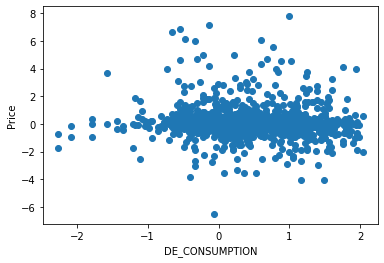

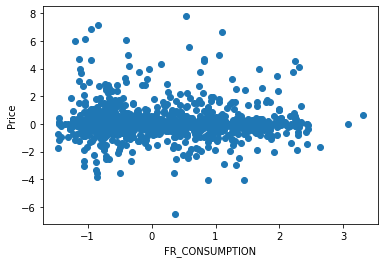

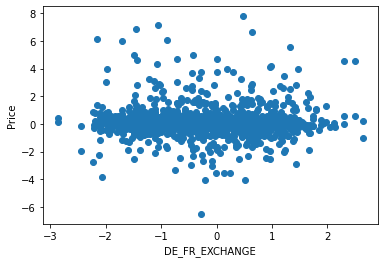

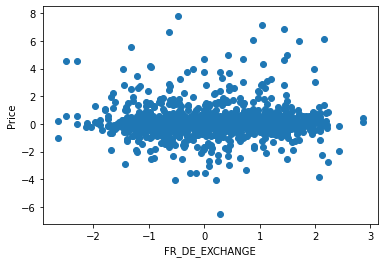

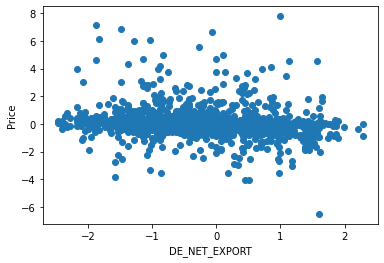

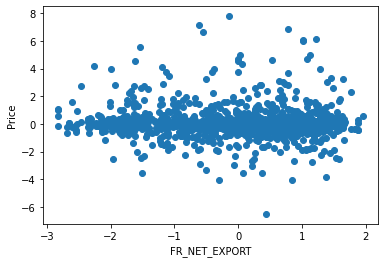

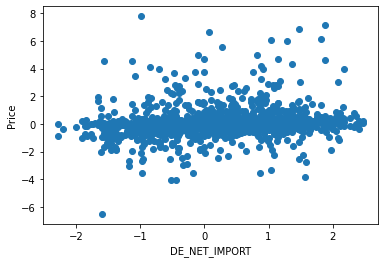

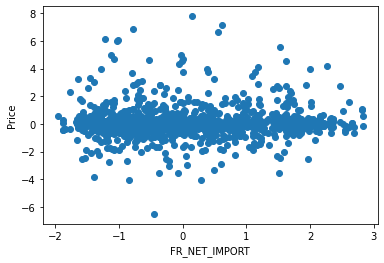

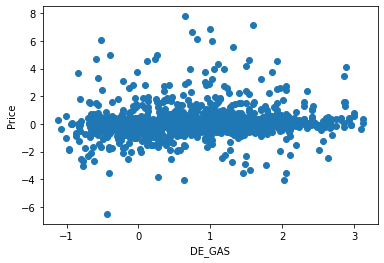

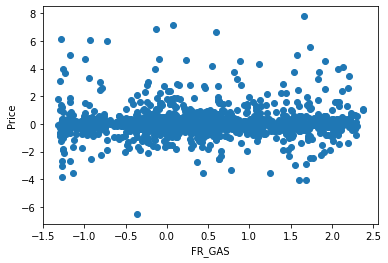

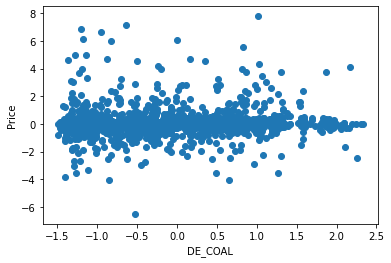

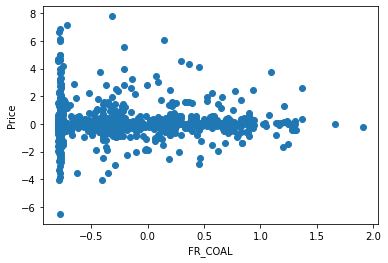

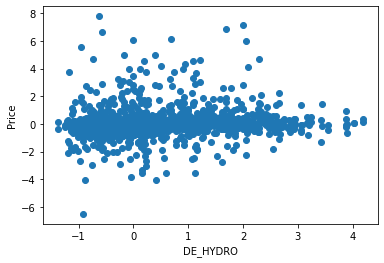

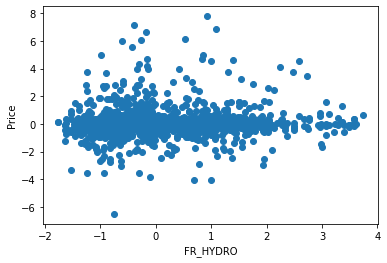

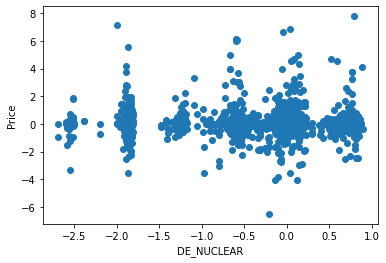

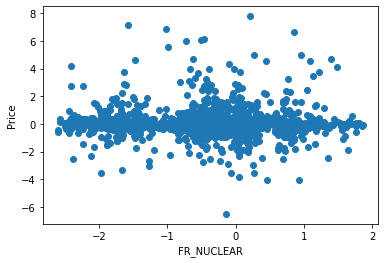

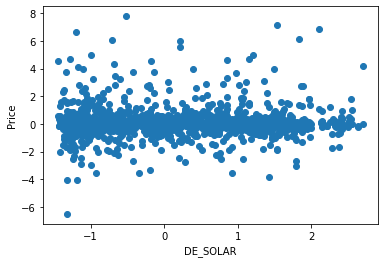

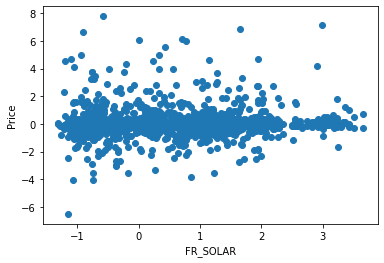

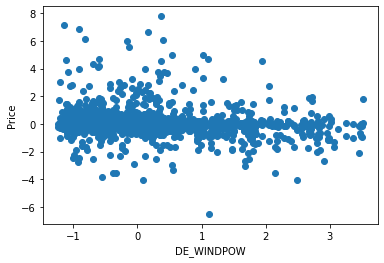

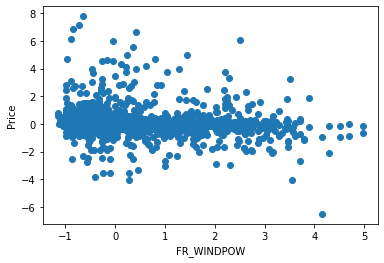

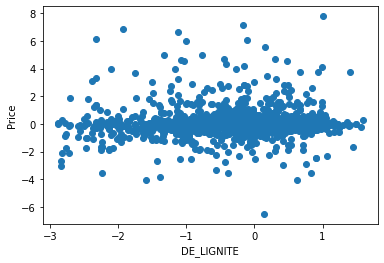

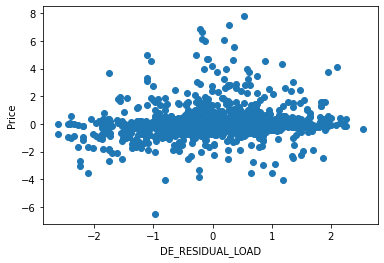

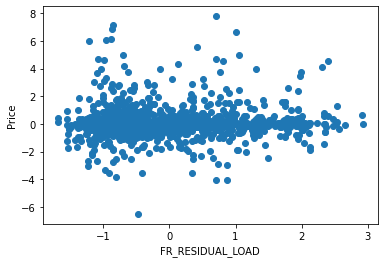

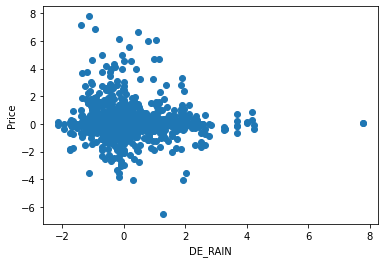

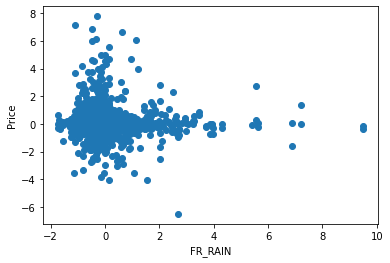

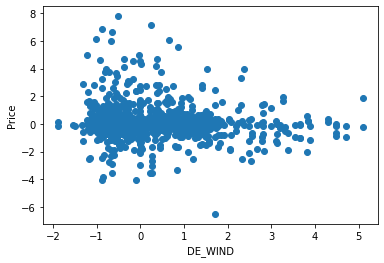

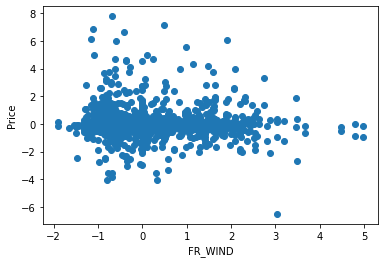

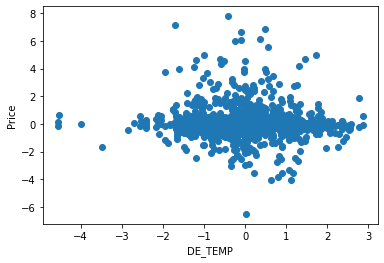

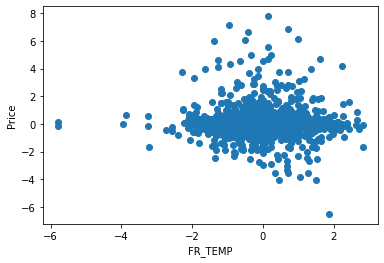

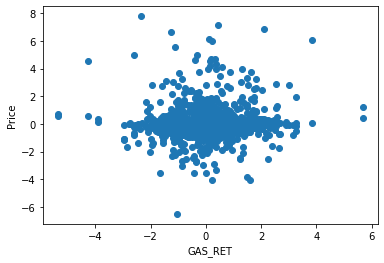

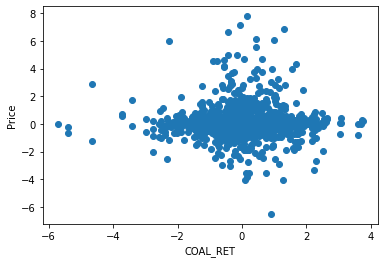

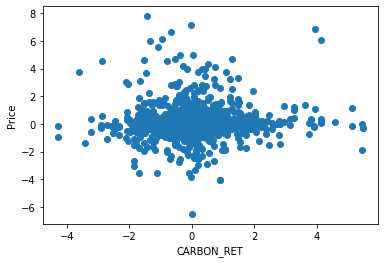

In [19]:
#on fait des graphs pour voir le lien entre TARGET (variation de prix à la journée) et les indices
for idx in X_train_clean.keys()[2:]:
    plt.scatter(list(X_train_clean[idx]), list(Y_train["TARGET"]) )
    plt.ylabel('Price')
    plt.xlabel(idx)
    plt.show()

On voit sur les graphes au-dessus des paquets. C'est difficile de voir s'ils sont corrélés. 

On va regarder le prix plutôt que la différence de prix. On veut voir si un cout plus élévé d'une ressource énergétique entraîne un surcout du prix de l'électricité et non seulement la variation. 

On a regardé le prix de l'électricité indépendemment du pays dans lequel on se situait. 

On appliquera les outils sur les Séries temporelles. En suite, on va untrender le signal. On va aussi regarder la périodicité du signal. On veut voir s'il y a pas un cycle hebdomadaire, mensuel, saisoner, annuel.


In [20]:
help(preprocessing)

NameError: name 'preprocessing' is not defined

In [22]:
###ON REGARDE SI LE PAYS JOUE DANS NOTRE VISION###

In [23]:
# on réalise une jointure afin de pouvoir ordonner l'ensemble du dataset
data= pd.merge(X_train,Y_train, on = ['ID'])

In [24]:
donnee_FR = data[data["COUNTRY"]=="FR"].fillna(0).sort_values('DAY_ID')
donnee_DE = data[data["COUNTRY"]=="DE"].fillna(0).sort_values('DAY_ID')

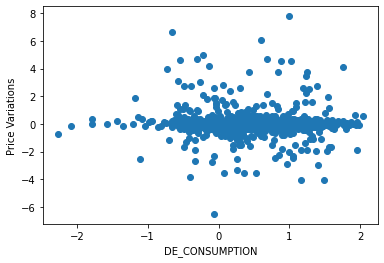

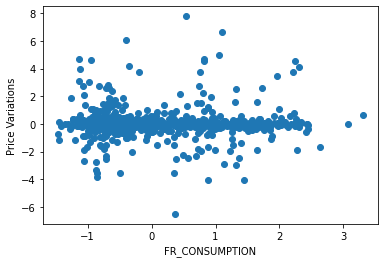

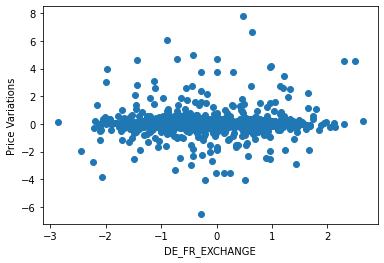

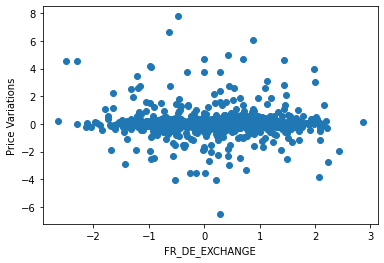

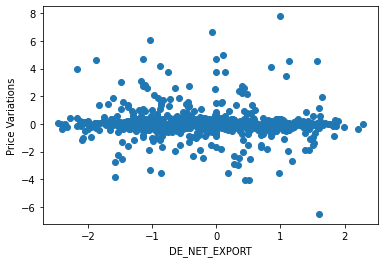

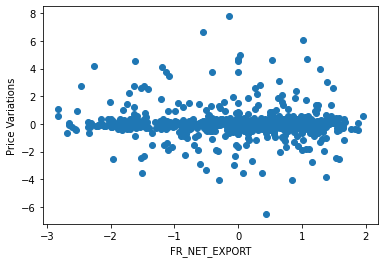

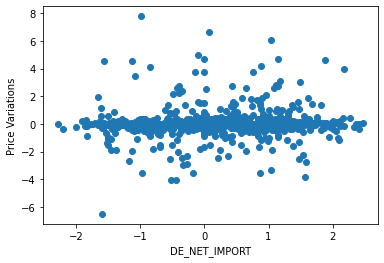

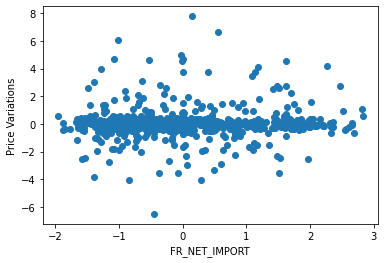

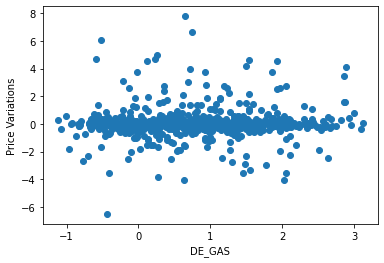

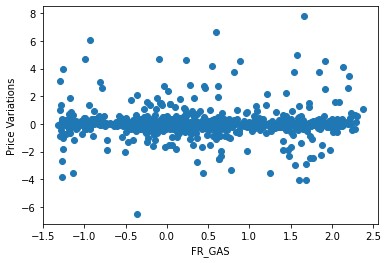

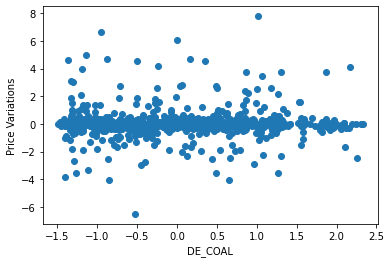

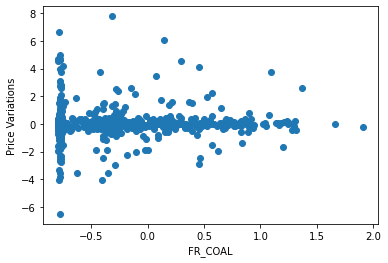

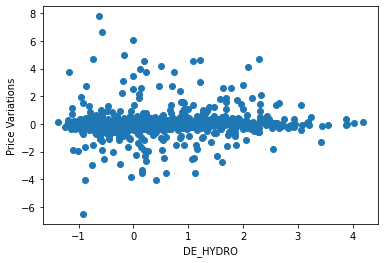

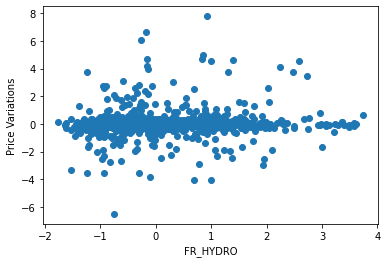

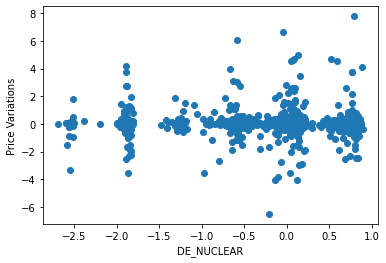

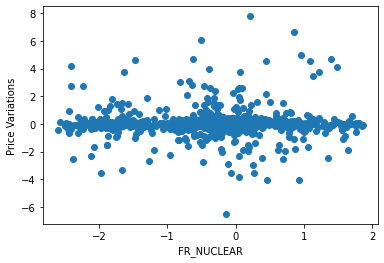

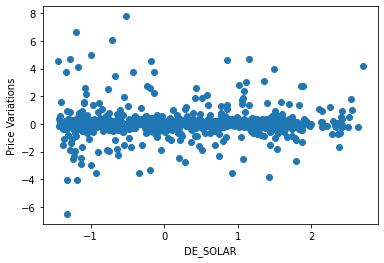

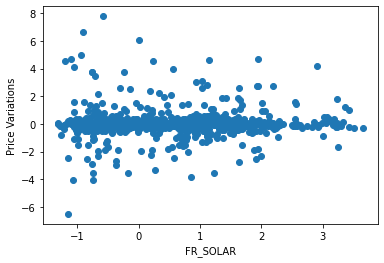

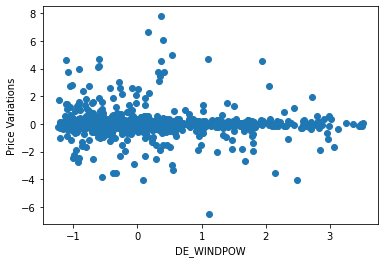

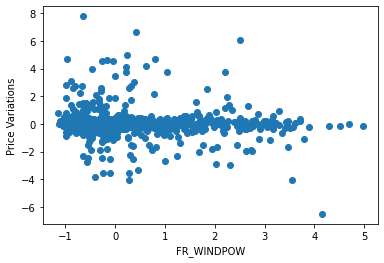

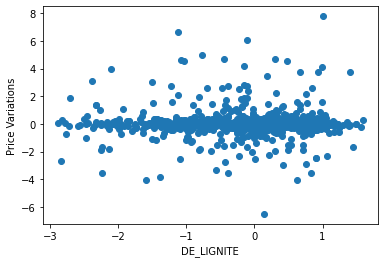

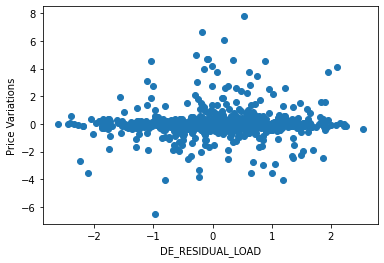

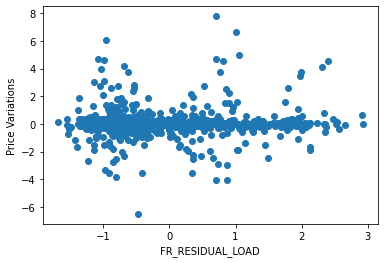

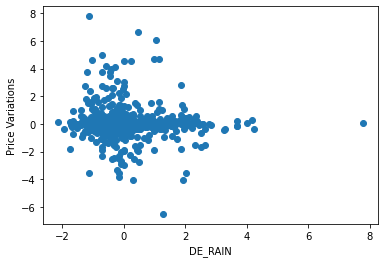

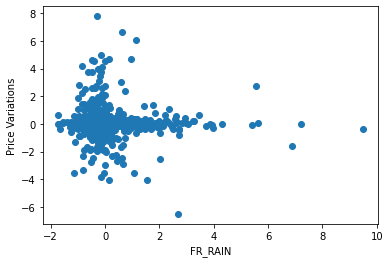

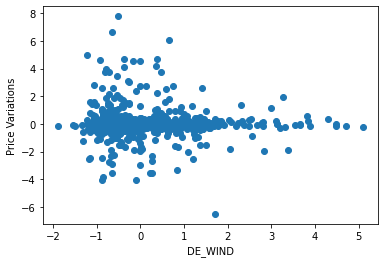

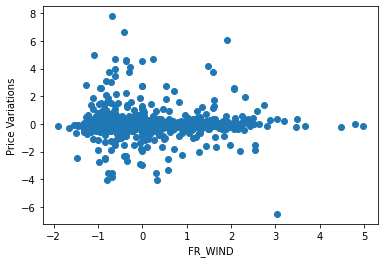

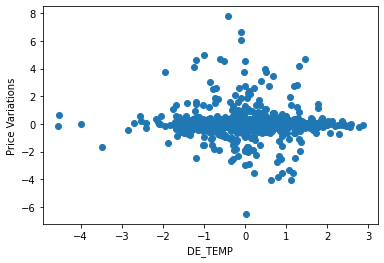

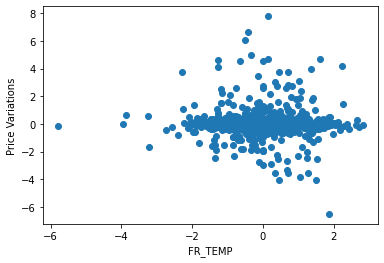

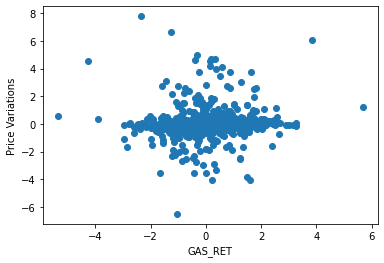

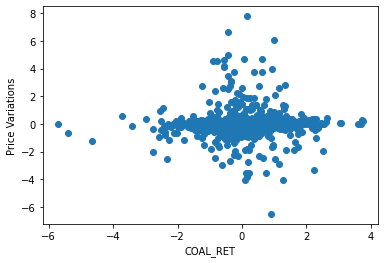

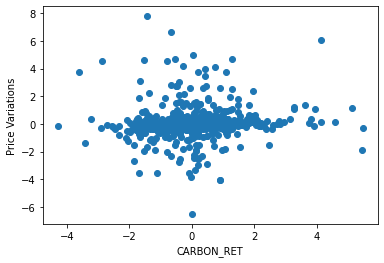

In [25]:
#on fait des graphs pour voir le lien entre différérence de prix et les indices
for idx in donnee_FR.keys()[3:35]:
    plt.scatter(list(donnee_FR[idx]), list(donnee_FR["TARGET"]) )
    plt.ylabel('Price Variations')
    plt.xlabel(idx)
    plt.show()

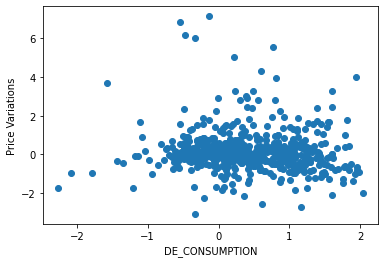

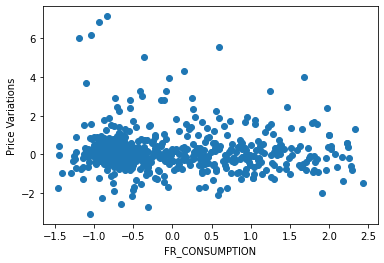

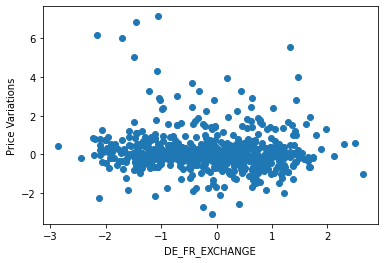

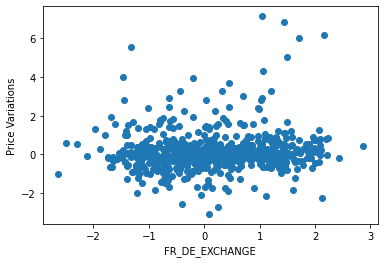

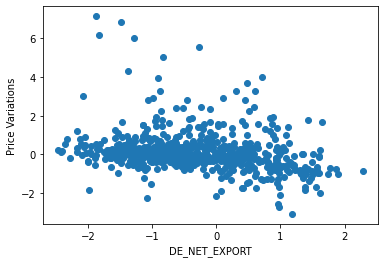

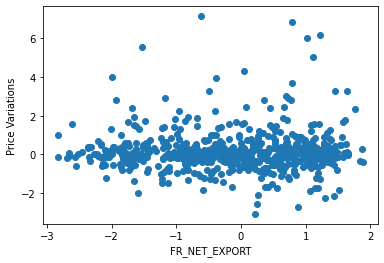

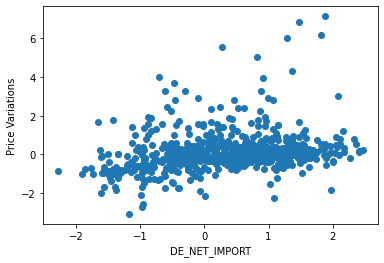

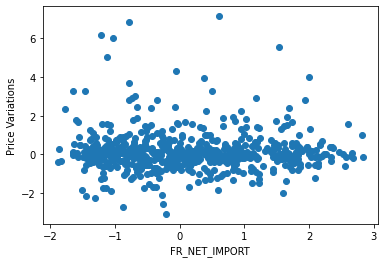

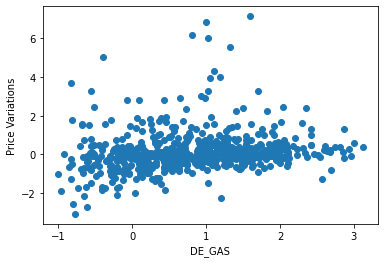

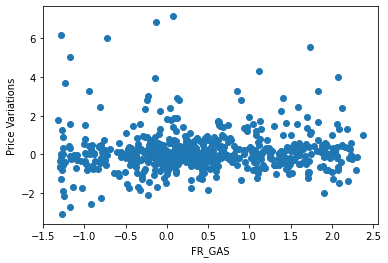

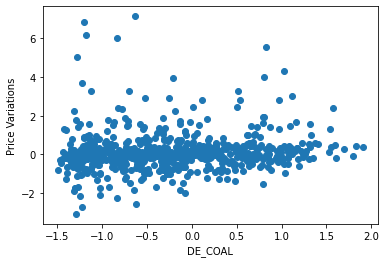

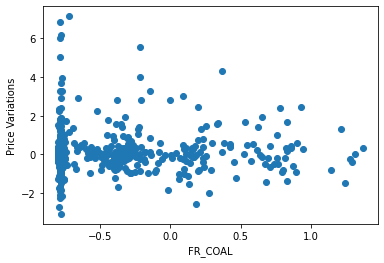

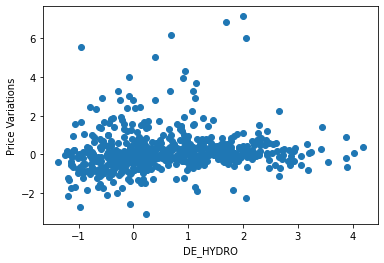

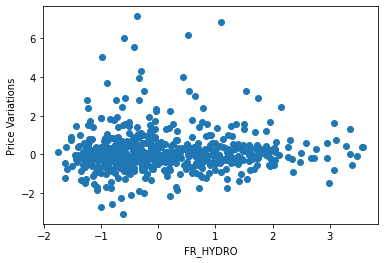

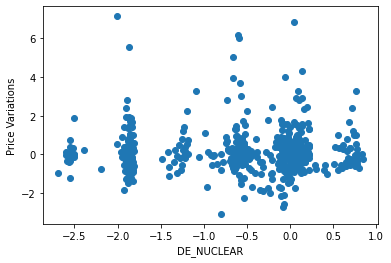

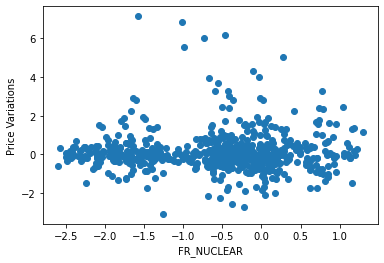

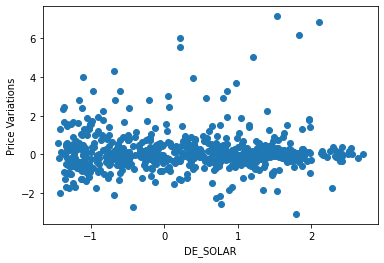

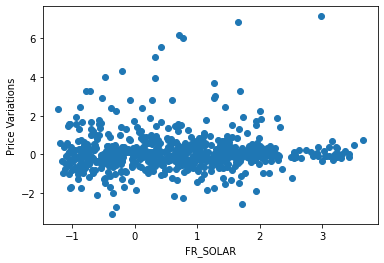

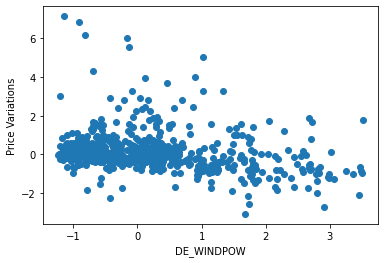

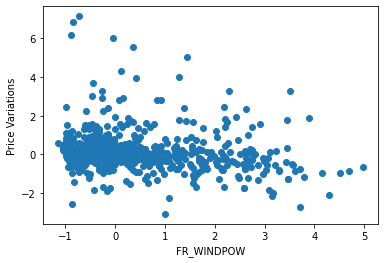

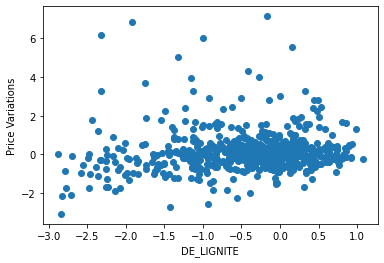

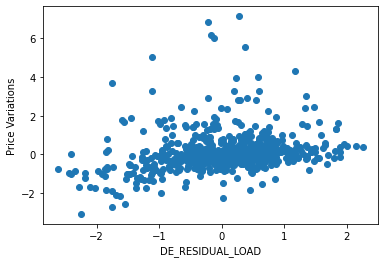

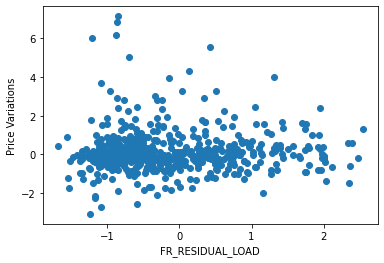

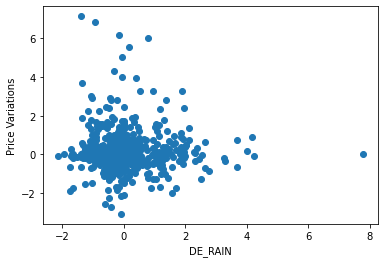

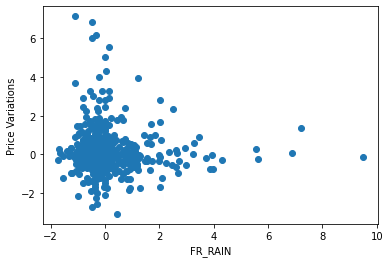

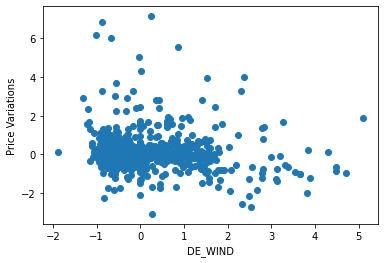

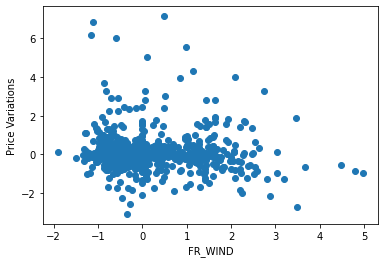

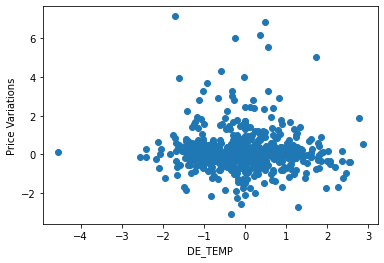

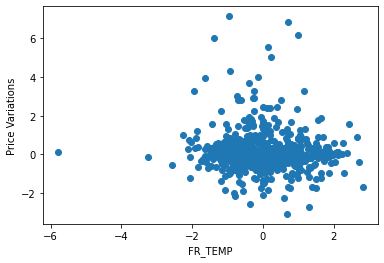

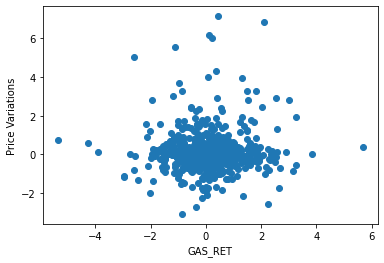

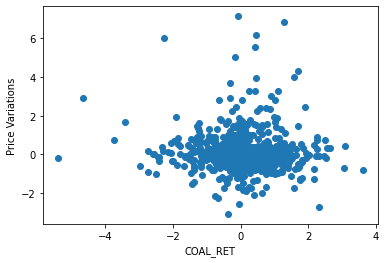

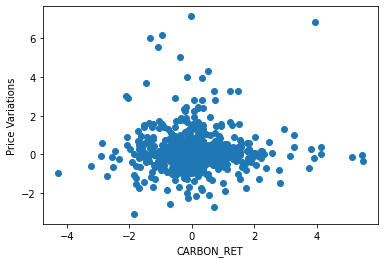

In [26]:
for idx in donnee_DE.keys()[3:35]:
    plt.scatter(list(donnee_DE[idx]), list(donnee_DE["TARGET"]) )
    plt.ylabel('Price Variations')
    plt.xlabel(idx)
    plt.show()

## Construction d'une feature prix

On veut construire le prix à partir des variations de prix. Pour un jour $n$, on a la variation de prix $\Delta_n = p_n - p_{n-1}$. On calcule alors le prix au jour $n$ en faisant la `cumsum()`. En effet, $\sum_{n=0}^N \Delta_n = p_N - p_{-1}$. 

Le problème est que tout les `DAY_ID` ne sont pas renseigné. Certains jours manquent. On approxime alors les $\Delta_n$ manquant par une moyenne arithmétique entre les valeurs du jours $n-1$ et $n-1$, cad $\Delta_n \simeq \frac{\Delta_{n-1}+\Delta_{n+1}}{2}$.

In [27]:
data_FR = donnee_FR.assign(PRICE = donnee_FR['TARGET'] )

In [28]:
## On approxime la pente de la fonction prix, si les temps ne sont pas successsifs, on dit c'est la moyenne
## des deux pentes

# ajouter une nouvelle colonne qui contient la somme de col1 pour la ligne actuelle et la ligne précédente
data_FR['Variation_Price'] = ( data_FR['DAY_ID'] - data_FR['DAY_ID'].shift(1) -1 )*(data_FR['TARGET'].shift(1) + 
                                                                        data_FR['TARGET']) /2   +  data_FR['TARGET']

##CALCUL DU PRIX##

# utiliser cumsum pour accumuler les valeurs de la nouvelle colonne
data_FR['PRICE'] = data_FR['Variation_Price'].cumsum()

data_FR

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET,PRICE,Variation_Price
742,1057,0,FR,0.048418,-0.465067,-0.079296,0.079296,0.000000,0.650577,0.000000,...,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,0.108953,NaN,NaN
1211,1179,1,FR,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,-0.063369,-0.063369,-0.063369
1408,1327,2,FR,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,2.575976,2.512607,2.575976
329,2016,3,FR,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0.068905,2.581512,0.068905
512,2047,5,FR,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1.031308,4.162926,1.581415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,2039,1208,FR,0.046568,-0.709011,0.427976,-0.427976,-0.578391,-1.678101,0.578391,...,0.472212,0.630211,1.065727,-1.439105,0.291714,0.568479,0.395742,0.136028,33.830516,0.136028
1451,972,1209,FR,1.109804,1.301061,1.565552,-1.565552,0.000000,0.000000,0.000000,...,-0.395438,-0.463636,-0.251075,-0.387127,-0.411589,1.774694,1.038661,-0.021766,33.808750,-0.021766
1007,1987,1212,FR,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,...,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,-0.425474,32.936036,-0.872714
873,1688,1213,FR,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,...,0.000000,0.000000,0.000000,0.000000,-0.103642,-0.633007,0.214805,-3.003988,29.932048,-3.003988


Text(0.5, 1.0, 'Electricity Prices in France')

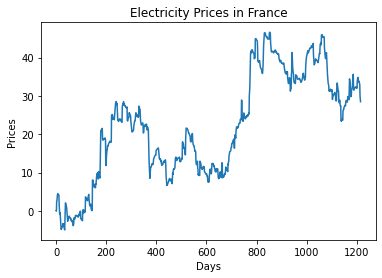

In [29]:
##On plot les évaluations de prix ainsi obtenus##

plt.plot(data_FR["DAY_ID"], data_FR["PRICE"].fillna(0))
plt.xlabel('Days')
plt.ylabel('Prices')
plt.title("Electricity Prices in France")

Le graphe montre une tendence haussière. Qui je pense est souvent le cas, à cause de l'inflation structurelle. 

### Graphs

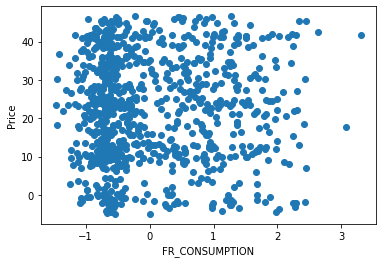

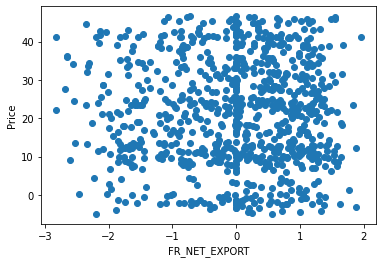

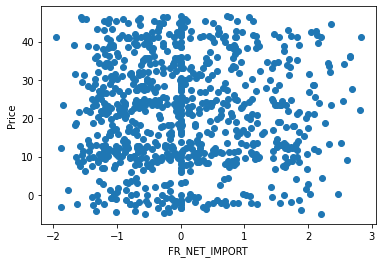

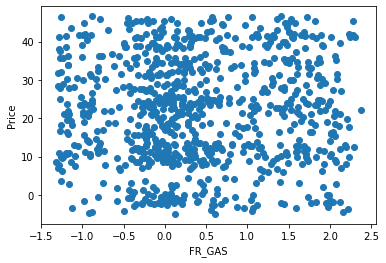

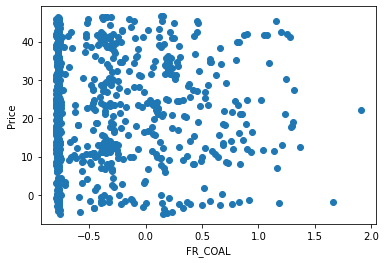

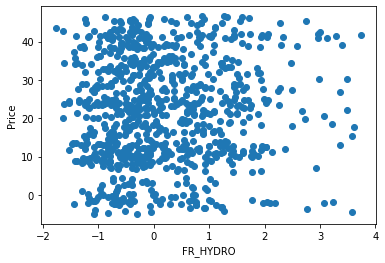

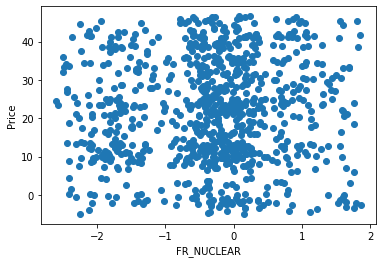

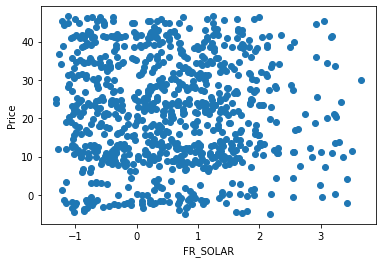

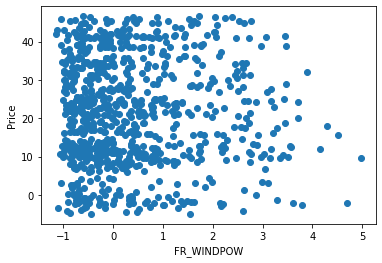

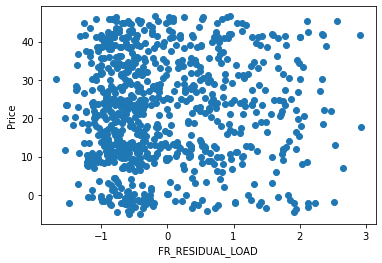

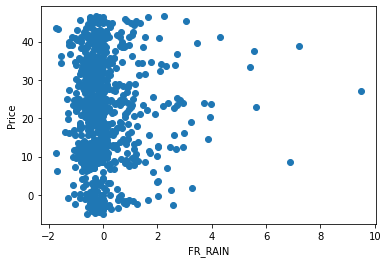

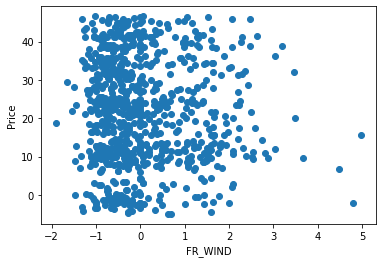

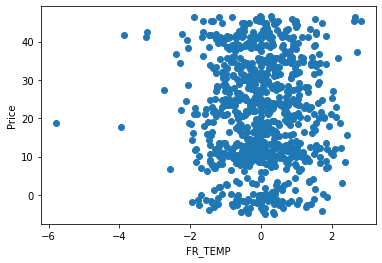

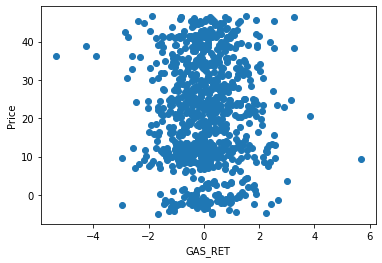

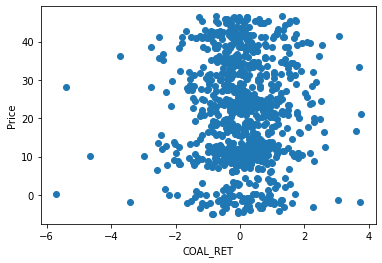

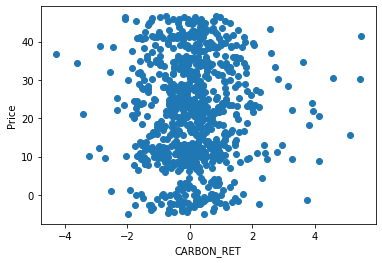

In [30]:
#on fait des graphs pour voir le lien entre différérence de prix et les indices
for idx in data_FR.keys()[3:35]:
    if not("DE" in idx):
        plt.scatter(list(data_FR[idx]), list(data_FR["PRICE"]) )
        plt.ylabel('Price')
        plt.xlabel(idx)
        plt.show()

### Correlation

In [31]:
#LETs CHECK IF THERE IS ANY CORRELATION BETWEEN PRICE AND ANY OTHER INDICES
corr =data_FR.corr()[['PRICE']]
corr_sort=corr.sort_values('PRICE', ascending=False)
corr_sort.style.background_gradient(cmap='coolwarm')
# Potentiellement intéressant de tracer les corrélations avec les jours d'avant.

,PRICE
PRICE,1.000000
DAY_ID,0.752368
FR_HYDRO,0.060242
DE_NUCLEAR,0.050086
FR_RESIDUAL_LOAD,0.046784
FR_NUCLEAR,0.042916
FR_CONSUMPTION,0.037682
Variation_Price,0.033611
DE_COAL,0.029679
DE_FR_EXCHANGE,0.026155


De moins bons résulats que pour la variation de prix, à part pour le day_id. On se reconcentre sur la variation de prix. 

### Utilisation de modèles pour cette nouvelle variable

On va utiliser les modèle de Neural Network, Random Forest, GBoost. Un feature doit être construit à partir des autres features, pas à partir du label!! Normalement, si on lui donne le prix, c'est censé pouvoir calculer la différence de prix.

In [32]:
data_FR = data_FR.fillna(0)

In [33]:
data_FR_clean = data_FR.drop(['COUNTRY'], axis=1)

In [34]:
data_FR_clean.head()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET,PRICE,Variation_Price
742,1057,0,0.048418,-0.465067,-0.079296,0.079296,0.000000,0.650577,0.000000,-0.650577,...,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,0.108953,0.000000,0.000000
1211,1179,1,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,-0.778627,...,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,-0.063369,-0.063369,-0.063369
1408,1327,2,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,-0.256736,...,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,2.575976,2.512607,2.575976
329,2016,3,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,0.612133,...,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0.068905,2.581512,0.068905
512,2047,5,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,1.811403,...,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1.031308,4.162926,1.581415


In [35]:
# DECOUPAGE DE LA DATA
# Attention au split qui ne prend pas en compte la chronologie de la data : les ordonner avant de split ?
from sklearn.model_selection import train_test_split

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(data_FR_clean.drop(['TARGET','Variation_Price'], axis=1), data_FR_clean["TARGET"], 
                                                    test_size=0.20, 
                                                    random_state=42)

In [36]:
# Modèle très naïf avec un seul prédicteur : Diviser en sous entrainements sur le dataset ?
from sklearn.ensemble import RandomForestRegressor

num_trees = 420
rf_regr = RandomForestRegressor(n_estimators = num_trees, random_state = 42,verbose=1)

rf_regr.fit(X_train_split, y_train_split)
output_split = rf_regr.predict(X_test_split)
print("Corrélation (Spearman) pour les données d'entrainement Random Forest : {:.1f}%".format(100 * spearmanr(output_split, y_test_split).correlation))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Corrélation (Spearman) pour les données d'entrainement Random Forest : 19.3%


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.0s finished


Random Forest achieves 90% accuracy when I give it the evaluated prices among the other indices. Mais si je mets seulement les estimations de prix alors le modèle retourne 1%(Bizarre cette affaire!)

Si je lui retire `Variation_Price` qui est la colonne qui correspond à la somme des variations $\sum_{i=p+1}^n\Delta_i$, où p est `DAY_ID` précédent le plus proche et $n$ est le `DAY_ID` de la colonne. Le score n'est plus que de 19%.

C'est normal la plus part du temps `Variation_Price` correspond exactement à la `TARGET`.  

## Corrrélation prix FRANCE et ALLEMAGNE

In [37]:
X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

In [38]:
donnee_FR = data[data["COUNTRY"]=="FR"].fillna(0).sort_values('DAY_ID')
donnee_DE = data[data["COUNTRY"]=="DE"].fillna(0).sort_values('DAY_ID')

In [39]:
donnee_FR[['DAY_ID','TARGET']]

,DAY_ID,TARGET
742,0,0.108953
1211,1,-0.063369
1408,2,2.575976
329,3,0.068905
512,5,1.031308
...,...,...
479,1208,0.136028
1451,1209,-0.021766
1007,1212,-0.425474
873,1213,-3.003988


In [40]:
TARGET_FR_DE = pd.merge(donnee_FR[['DAY_ID','TARGET']],donnee_DE[['DAY_ID','TARGET']], on = ['DAY_ID'])

In [41]:
#LETs CHECK IF THERE IS ANY CORRELATION BETWEEN PRICE AND ANY OTHER INDICES
corr = TARGET_FR_DE.corr()[['TARGET_x']]
corr.drop(['TARGET_x'], axis=0)

,TARGET_x
DAY_ID,-0.029126
TARGET_y,0.092916


We see that the prices are 10% between France and Germany are 10% correlated.

In [42]:
##SHOW THE CORRELATION OF ALL VARIABLES###
corr = donnee_FR.corr()
corr

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
ID,1.000000,-0.052633,-0.122745,-0.190134,0.216617,-0.216617,-0.164988,-0.469411,0.164988,0.469411,...,-0.022635,-0.020496,0.654362,0.678112,0.046090,0.094046,0.066085,-0.025066,0.030683,-0.010347
DAY_ID,-0.052633,1.000000,-0.031598,-0.006534,0.014670,-0.014670,0.033509,0.021729,-0.033509,-0.021729,...,0.030293,-0.022125,0.007596,-0.009161,0.016665,0.039686,-0.021643,-0.023495,0.002951,-0.025336
DE_CONSUMPTION,-0.122745,-0.031598,1.000000,0.817513,0.428645,-0.428645,0.531075,-0.120891,-0.531075,0.120891,...,0.127067,0.058837,0.149077,0.064393,0.020165,-0.140427,-0.053785,0.046824,-0.009315,-0.048551
FR_CONSUMPTION,-0.190134,-0.006534,0.817513,1.000000,0.490970,-0.490970,0.507046,-0.208419,-0.507046,0.208419,...,0.046560,0.019971,-0.025782,-0.067217,-0.094174,-0.234185,-0.097832,0.021157,-0.055423,0.009998
DE_FR_EXCHANGE,0.216617,0.014670,0.428645,0.490970,1.000000,-1.000000,0.676295,-0.641375,-0.676295,0.641375,...,-0.036570,-0.019969,0.323433,0.180894,-0.004940,-0.055548,-0.035316,-0.033215,-0.017579,0.035013
FR_DE_EXCHANGE,-0.216617,-0.014670,-0.428645,-0.490970,-1.000000,1.000000,-0.676295,0.641375,0.676295,-0.641375,...,0.036570,0.019969,-0.323433,-0.180894,0.004940,0.055548,0.035316,0.033215,0.017579,-0.035013
DE_NET_EXPORT,-0.164988,0.033509,0.531075,0.507046,0.676295,-0.676295,1.000000,-0.181110,-1.000000,0.181110,...,0.082126,0.070964,0.242096,0.053357,0.097447,0.025026,-0.088421,-0.019910,-0.084284,-0.066347
FR_NET_EXPORT,-0.469411,0.021729,-0.120891,-0.208419,-0.641375,0.641375,-0.181110,1.000000,0.181110,-1.000000,...,0.121963,0.053583,-0.280859,-0.228519,0.040625,0.059953,0.027479,0.022480,-0.026617,-0.042447
DE_NET_IMPORT,0.164988,-0.033509,-0.531075,-0.507046,-0.676295,0.676295,-1.000000,0.181110,1.000000,-0.181110,...,-0.082126,-0.070964,-0.242096,-0.053357,-0.097447,-0.025026,0.088421,0.019910,0.084284,0.066347
FR_NET_IMPORT,0.469411,-0.021729,0.120891,0.208419,0.641375,-0.641375,0.181110,-1.000000,-0.181110,1.000000,...,-0.121963,-0.053583,0.280859,0.228519,-0.040625,-0.059953,-0.027479,-0.022480,0.026617,0.042447


In [43]:
threshold = 0.7
indices_cor = []

for i in range(1,len(corr.index)):
    for j in range(1,len(corr.index)):
        if i < j :
            if abs(corr.iloc[i][j]) > threshold and abs(corr.iloc[i][j]) != 1.0:
                print(f"Correlation of {corr.index[i]} and {corr.columns[j]} is {corr.iloc[i][j]}")
                indices_cor.append(( corr.index[i], corr.columns[j] ))


Correlation of DE_CONSUMPTION and FR_CONSUMPTION is 0.8175130066680557
Correlation of DE_CONSUMPTION and FR_RESIDUAL_LOAD is 0.7644700095244582
Correlation of FR_CONSUMPTION and FR_GAS is 0.779585027390842
Correlation of FR_CONSUMPTION and FR_NUCLEAR is 0.7210129726412076
Correlation of FR_CONSUMPTION and FR_RESIDUAL_LOAD is 0.9672142605665384
Correlation of DE_NET_EXPORT and DE_WINDPOW is 0.7000490425641009
Correlation of DE_NET_IMPORT and DE_WINDPOW is -0.7000490425641009
Correlation of FR_GAS and FR_RESIDUAL_LOAD is 0.7918843484309606
Correlation of DE_COAL and DE_LIGNITE is 0.73574287745392
Correlation of FR_NUCLEAR and FR_RESIDUAL_LOAD is 0.7368700011329063
Correlation of DE_SOLAR and FR_SOLAR is 0.8017949502832276
Correlation of DE_WINDPOW and DE_RESIDUAL_LOAD is -0.7081608390684109
Correlation of DE_LIGNITE and DE_RESIDUAL_LOAD is 0.7166951035852108
Correlation of DE_WIND and FR_WIND is 0.8248565286047496


On remarque que certaines variables ne sont que l'opposé de l'autre notammant : 
<br><tab>            - DE_FR_EXCHANGE and FR_DE_EXCHANGE
<br><tab>            - DE_NET_EXPORT and DE_NET_IMPORT 
<br><tab>            - FR_NET_EXPORT and FR_NET_IMPORT 
    
    
On pourrait essayer de monter un algo de machine learning qui prédit la 2nde variable avec la première. Ainsi on peut réduire par beaucoup le nombre de variables au début. Le modèle finale a alors peu de paramètre et l'optimum a ainsi moins de chance d'être un overfit.     

In [44]:
##Meme chose pour l'Allemagne###

corr2 = donnee_DE.corr()

threshold = 0.7
indices_cor2 = []

for i in range(1,len(corr2.index)):
    for j in range(1,len(corr2.index)):
        if i < j :
            if abs(corr2.iloc[i][j]) > threshold and abs(corr2.iloc[i][j]) != 1.0:
                print(f"Correlation of {corr2.index[i]} and {corr2.columns[j]} is {corr2.iloc[i][j]}")
                indices_cor2.append(( corr2.index[i], corr2.columns[j] ))


Correlation of DE_CONSUMPTION and FR_CONSUMPTION is 0.8074579261393175
Correlation of DE_CONSUMPTION and FR_RESIDUAL_LOAD is 0.7395099035346862
Correlation of FR_CONSUMPTION and FR_GAS is 0.7839626952499126
Correlation of FR_CONSUMPTION and FR_RESIDUAL_LOAD is 0.9617615353279656
Correlation of DE_FR_EXCHANGE and FR_NET_EXPORT is -0.705355307701233
Correlation of DE_FR_EXCHANGE and FR_NET_IMPORT is 0.705355307701233
Correlation of FR_DE_EXCHANGE and FR_NET_EXPORT is 0.705355307701233
Correlation of FR_DE_EXCHANGE and FR_NET_IMPORT is -0.705355307701233
Correlation of DE_NET_EXPORT and DE_WINDPOW is 0.7779753383058875
Correlation of DE_NET_IMPORT and DE_WINDPOW is -0.7779753383058875
Correlation of DE_GAS and DE_RESIDUAL_LOAD is 0.7559345156106129
Correlation of FR_GAS and FR_RESIDUAL_LOAD is 0.8089149535683956
Correlation of DE_SOLAR and FR_SOLAR is 0.8045482972620283
Correlation of DE_WINDPOW and DE_RESIDUAL_LOAD is -0.7050204877761505
Correlation of DE_LIGNITE and DE_RESIDUAL_LOAD is 

In [45]:
for tup in indices_cor2 :
    print(tup in indices_cor)
    
print("\n\n") 

for tup in indices_cor :
    print(tup in indices_cor2)

True
True
True
True
False
False
False
False
True
True
False
True
True
True
True
True



True
True
True
False
True
True
True
True
False
False
True
True
True
True


In [46]:
((abs(corr - corr2) < 0.05).drop("ID", axis =0).drop("ID", axis =1))

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET
DAY_ID,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,True,True,True
DE_CONSUMPTION,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,False,True,True,True,True,True
FR_CONSUMPTION,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,False,False,False,True,True,True
DE_FR_EXCHANGE,True,True,True,True,True,True,False,True,False,False,...,True,True,False,False,False,False,True,True,True,False
FR_DE_EXCHANGE,True,True,True,True,True,True,False,True,False,False,...,True,True,False,False,False,False,True,True,True,False
DE_NET_EXPORT,True,True,True,True,True,True,False,True,False,True,...,True,True,False,False,True,True,True,True,True,False
FR_NET_EXPORT,True,True,True,False,False,False,True,False,True,True,...,True,True,True,True,False,False,True,True,True,True
DE_NET_IMPORT,True,True,True,True,True,True,False,True,False,True,...,True,True,False,False,True,True,True,True,True,False
FR_NET_IMPORT,True,True,True,False,False,False,True,False,True,True,...,True,True,True,True,False,False,True,True,True,True
DE_GAS,True,True,True,False,False,True,True,True,True,True,...,True,True,False,False,False,False,True,True,True,False


In [47]:
print(((abs(corr - corr2) < 0.245).drop("ID", axis =0).drop("ID", axis =1)).sum().sum())

1156


Quand on prend une différence de 0.05 au maximum, la différence de corrélation selon le pays Allemagne et France ne dépasse pas que pour 1156-818 = 338 indices. 

Quand on autorise une différence de 10%, on obtiens que 1030 corrélations sont les mêmes. 

Quand on autorise 15 %, 1106 sont les mêmes. 

24,6 % toutes les corrélations sont les mêmes.

## Quelques Modèles

In [48]:
don_f = donnee_FR.drop(["FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT","DE_CONSUMPTION","DE_WIND","DE_SOLAR", "FR_GAS","COUNTRY","DE_LIGNITE","DE_RAIN"], axis =1) 
don_d = donnee_DE.drop(["FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT","COUNTRY"], axis =1) 

In [49]:
don_f['FR_RESIDUAL_LOAD-1'] = don_f['FR_RESIDUAL_LOAD'].shift(1) 
don_f['FR_CONSUMPTION-1'] = don_f['FR_CONSUMPTION'].shift(1) 
don_f['DAY_ID-1'] = don_f['DAY_ID'].shift(1)
                                                                        

In [50]:
don_f =don_f.fillna(0)

In [51]:
# DECOUPAGE DE LA DATA
# Attention au split qui ne prend pas en compte la chronologie de la data : les ordonner avant de split ?
from sklearn.model_selection import train_test_split

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(don_f.drop(['TARGET'], axis=1), don_f["TARGET"], 
                                                    test_size=0.20, 
                                                    random_state=42)

In [52]:
# Modèle très naïf avec un seul prédicteur : Diviser en sous entrainements sur le dataset ?
from sklearn.ensemble import RandomForestRegressor

num_trees = 420
rf_regr = RandomForestRegressor(n_estimators = num_trees, random_state = 42,verbose=1)

rf_regr.fit(X_train_split, y_train_split)
output_split = rf_regr.predict(X_test_split)
print("Corrélation (Spearman) pour les données d'entrainement Random Forest : {:.1f}%".format(100 * spearmanr(output_split, y_test_split).correlation))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Corrélation (Spearman) pour les données d'entrainement Random Forest : 24.1%


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed:    0.0s finished


Score inchangé de 19.3% quand on retire `FR_DE_EXCHANGE`, `DE_NET_IMPORT`, `FR_NET_IMPORT`

19,5 % quand on retire `FR_DE_EXCHANGE`, `DE_NET_IMPORT`, `FR_NET_IMPORT`, `DE_CONSUMPTION`, `DE_WIND`, `DE_SOLAR` pour l'estimation en France

20.0% quand on retire `FR_DE_EXCHANGE`, `DE_NET_IMPORT`, `FR_NET_IMPORT`, `DE_CONSUMPTION`,`DE_WIND`,`DE_SOLAR` pour l'estimation en France et on ajoute `FR_RESIDUAL_LOAD-1` , `FR_CONSUMPTION-1` , `DAY_ID-1`

20.8% en retirant `FR_DE_EXCHANGE`, `DE_NET_IMPORT`, `FR_NET_IMPORT`, `DE_CONSUMPTION`,`DE_WIND`,`DE_SOLAR`, `FR_GAS` et en ajotant `FR_RESIDUAL_LOAD-1` , `FR_CONSUMPTION-1` , `DAY_ID-1`

22% en retirant `DE_LIGNITE`

23.3% en retirant `DE_WINDPOW`

24.1% en retirant `DE_RAIN` mais en laissant `DE_WINDPOW`

In [53]:
Correlation of DE_CONSUMPTION and FR_CONSUMPTION is 0.8175130066680557
Correlation of DE_CONSUMPTION and FR_RESIDUAL_LOAD is 0.7644700095244582
Correlation of FR_CONSUMPTION and FR_GAS is 0.779585027390842
Correlation of FR_CONSUMPTION and FR_NUCLEAR is 0.7210129726412076
Correlation of FR_CONSUMPTION and FR_RESIDUAL_LOAD is 0.9672142605665384
Correlation of DE_NET_EXPORT and DE_WINDPOW is 0.7000490425641009
Correlation of DE_NET_IMPORT and DE_WINDPOW is -0.7000490425641009
Correlation of FR_GAS and FR_RESIDUAL_LOAD is 0.7918843484309606
Correlation of DE_COAL and DE_LIGNITE is 0.73574287745392
Correlation of FR_NUCLEAR and FR_RESIDUAL_LOAD is 0.7368700011329063
Correlation of DE_SOLAR and FR_SOLAR is 0.8017949502832276
Correlation of DE_WINDPOW and DE_RESIDUAL_LOAD is -0.7081608390684109
Correlation of DE_LIGNITE and DE_RESIDUAL_LOAD is 0.7166951035852108
Correlation of DE_WIND and FR_WIND is 0.8248565286047496

SyntaxError: invalid syntax (2623019528.py, line 1)

In [ ]:
don_d['FR_RESIDUAL_LOAD-1'] = don_f['FR_RESIDUAL_LOAD'].shift(1) 
don_d['FR_CONSUMPTION-1'] = don_f['FR_CONSUMPTION'].shift(1) 
don_d['DAY_ID-1'] = don_f['DAY_ID'].shift(1)

In [ ]:
don_d =don_f.fillna(0)

In [ ]:
# DECOUPAGE DE LA DATA
# Attention au split qui ne prend pas en compte la chronologie de la data : les ordonner avant de split ?
from sklearn.model_selection import train_test_split

X_train_split_DE, X_test_split_DE, y_train_split_DE, y_test_split_DE = train_test_split(don_d.drop(['TARGET'], axis=1), don_d["TARGET"], 
                                                    test_size=0.20, 
                                                    random_state=42)

In [ ]:
# Modèle très naïf avec un seul prédicteur : Diviser en sous entrainements sur le dataset ?
from sklearn.ensemble import RandomForestRegressor

num_trees = 420
rf_regr_DE = RandomForestRegressor(n_estimators = num_trees, random_state = 42,verbose=1)

rf_regr_DE.fit(X_train_split_DE, y_train_split_DE)
output_split_DE = rf_regr_DE.predict(X_test_split_DE)
print("Corrélation (Spearman) pour les données d'entrainement Random Forest : {:.1f}%".format(100 * spearmanr(output_split_DE, y_test_split_DE).correlation))

## Predire la valeur à t avec celle à t-1

In [ ]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(data.drop(['TARGET'], axis=1), data[["ID","TARGET"]], 
                                                    test_size=0.20, 
                                                    random_state=42)

In [ ]:
y_test_split

In [54]:
def model(dataFrame_test, dataFrame_train,y_train_split):
    dataFrame_train.sort_values('DAY_ID')
    y_test = []
    for index, row in dataFrame_test.iterrows():
        country = row["COUNTRY"]
        DAY =  row["ID_DAY"]
        for i in range(40):
            if int(DAY-i) in dataFrame_train["DAY_ID"]:
                ID = dataFrame_train[X_train_split["DAY_ID"] == int(DAY-i)]["ID"].item()
                
                
            elif int(DAY+i) in dataFrame_train["DAY_ID"]:
                ID = dataFrame_train[X_train_split["DAY_ID"] == int(DAY+i)]["ID"].item()
                
            y_test.append( (y_train_split[y_train_split['ID']==ID])['TARGET'].item() )  #dataset sur country et day  +i    
            break
                
    
    

In [162]:
model(X_test_split, X_train_split,y_train_split)

KeyError: 'ID_DAY'

In [143]:
X_train_split[X_train_split["DAY_ID"] == int(15)]["ID"].item()

1106

In [150]:
(y_train_split[y_train_split['ID']==1106])['TARGET'].item()

-0.1237394347270676

## Création de nouvelles variables produits ou sommes

On va regarder la corrélation

In [187]:

X_train = pd.read_csv('X_train.csv') #même ID à la même ligne
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

X_train = pd.get_dummies(X_train, columns=["COUNTRY"])
X_test = pd.get_dummies(X_test, columns=["COUNTRY"])

In [188]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [196]:
donnee = pd.merge(X_train,Y_train, on = ['ID'])
donnee = donnee.sort_values('DAY_ID')

In [200]:
(donnee['COUNTRY_DE']==0).sum()

851

643 valeurs pour l'allemagne, 851 pour la France

In [205]:
donnee_clean = donnee.drop(["FR_DE_EXCHANGE", "DE_NET_IMPORT", "FR_NET_IMPORT","COUNTRY_DE"], axis =1)

In [206]:
# DECOUPAGE DE LA DATA
# Attention au split qui ne prend pas en compte la chronologie de la data : les ordonner avant de split ?
from sklearn.model_selection import train_test_split

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(donnee_clean.drop(['ID'], axis = 1 ), donnee_clean['TARGET'], 
                                                    test_size=0.20, 
                                                    random_state=42)

In [209]:
X_train.keys()

Index(['ID', 'DAY_ID', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_NET_IMPORT',
       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'COUNTRY_DE',
       'COUNTRY_FR'],
      dtype='object')

In [ ]:
# Modèle très naïf avec un seul prédicteur : Diviser en sous entrainements sur le dataset ?
from sklearn.ensemble import RandomForestRegressor

num_trees = 420
rf_regr = RandomForestRegressor(n_estimators = num_trees, random_state = 42,verbose=1)

rf_regr.fit(X_train_split, y_train_split)
output_split = rf_regr.predict(X_test_split)
print("Corrélation (Spearman) pour les données d'entrainement Random Forest : {:.1f}%".format(100 * spearmanr(output_split, y_test_split).correlation))

## Untrending and periodogram sur les variations de prix

Ici on voudrait utiliser nos connaissances sur les Séries Temporelles. Attention, comment adapter nos connaissances sur le prédiction de Série temporelle à retrouver les valeurs manquantes dans la série temporelle. 


Ici on a plusieurs paramètres en entrées, traiter ça comme time series reviendrait juste à garder les attributs `DAY_ID` et `TARGET`.

In [145]:
data_FR

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET,PRICE,Variation_Price
742,1057,0,FR,0.048418,-0.465067,-0.079296,0.079296,0.000000,0.650577,0.000000,...,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,0.108953,NaN,NaN
1211,1179,1,FR,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,-0.063369,-0.063369,-0.063369
1408,1327,2,FR,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.140920,0.900434,2.575976,2.512607,2.575976
329,2016,3,FR,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.064550,-0.032756,0.068905,2.581512,0.068905
512,2047,5,FR,-0.297850,-0.470371,0.144615,-0.144615,-1.208286,-1.811403,1.208286,...,0.333817,0.021868,-0.062187,1.459745,-0.117977,0.550433,0.781870,1.031308,4.162926,1.581415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,2039,1208,FR,0.046568,-0.709011,0.427976,-0.427976,-0.578391,-1.678101,0.578391,...,0.472212,0.630211,1.065727,-1.439105,0.291714,0.568479,0.395742,0.136028,33.830516,0.136028
1451,972,1209,FR,1.109804,1.301061,1.565552,-1.565552,0.000000,0.000000,0.000000,...,-0.395438,-0.463636,-0.251075,-0.387127,-0.411589,1.774694,1.038661,-0.021766,33.808750,-0.021766
1007,1987,1212,FR,-0.046100,-0.520506,-0.270515,0.270515,-0.137917,-0.789824,0.137917,...,1.358211,1.123953,-0.707839,-0.308232,0.017778,0.072168,-0.160792,-0.425474,32.936036,-0.872714
873,1688,1213,FR,1.407027,1.313254,-0.456126,0.456126,0.333142,-0.069222,-0.333142,...,0.000000,0.000000,0.000000,0.000000,-0.103642,-0.633007,0.214805,-3.003988,29.932048,-3.003988


Text(0.5, 1.0, 'Periodogram of the target')

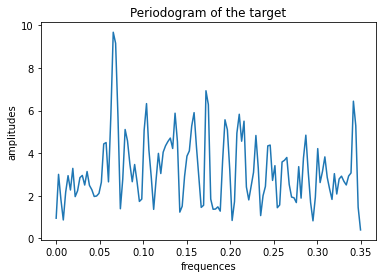

In [156]:
arr = data_FR["TARGET"].to_numpy()
dt = data_FR["DAY_ID"].to_numpy()

from scipy.signal import welch


freqs, Pxx = welch(arr,  1 / np.mean(np.diff(dt))) #number of points observed evevery diff of index


plt.plot(freqs, Pxx)
plt.ylabel("amplitudes")
plt.xlabel('frequences')
plt.title("Periodogram of the target")


In [158]:
from scipy.signal import find_peaks
freqs[find_peaks(Pxx, prominence=1e7, distance=1)[0]]

array([], dtype=float64)

In [72]:
u = correlate(donnee_FR[['TARGET']],donnee_FR[['TARGET']])
xx = u.reshape(-1)
xx/= np.array([xx.shape[0] - abs(xx.shape[0]//2 -n) for n in range(xx.shape[0])])

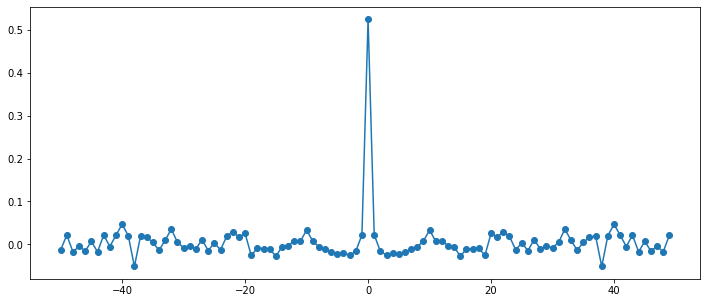

In [86]:
fig = plt.figure(figsize=(12, 5))
plt.plot(range(-50,50,1), xx[xx.shape[0]//2-50 : xx.shape[0]//2+50], marker='o' )  
